In [ ]:
# GOAL : What am I searching for ?
        # => To predict with the best possible accuracy (proba) an event (+/- xx% variation of close_price)
        # What for ?
            # => To be able to balance my portfolio (sell what should go down for what should go up)
            # => Sell crypto for Stable coin / Or buy crypto with Stable Coin
            
            ######## => Add info about trend 1h, 12h, 24h, 3d, 7d, 15d, 30d, ?
########

In [ ]:
# Advices : 
    # Be careful to scaling, min / max can change in the future...

In [ ]:
# TODO Now :
    # 1 / Industrialization : 
        # Dataset for TOP 20 cryptos + capacity to learn from top 20 and predict 1 : EC - cf. preprocess - get_global_dataset_for_cryptos()
        # Test auto de tous les algos pour différentes cryptos et création d'un "rapport" exploitable pour voir ce qui est bien ou non
    # 2 / Construire algo de strategy backtest Buy / Sell + indicateur de stratégie (prendre en compte prévisions d'augmentation et prévisions de baisse)
    # 3 / Gérer le fait qu'on a des dataset déséquilibrés ?
    # 4 / Gérer l'overfitting de ouf

In [ ]:
# TODO : 
    # 0 / Read : What is being done elsewhere, feature enginerring, algo, etc.
    # 1 / Testing phase + take ownership of the code
        # 1.1 / Test y_value and y_classif to be sure it's well calculated
        # 1.2 / Understand well what the code is doing end-to-end
    # 2 / Data vizualisation : Re-read MOOC + articles, what can I do ? Correlations, etc. => Visiblement aime bien les booleans !
    # 3 / Choose features + add with features engineering if needed
        # 3.1 / Other indicators - 10d-20d-30d, etc. ?
        # 3.2 / Add info about trend 1h, 12h, 24h, 3d, 7d, 15d, 30d, etc. ?
        # 3.3 / Volume indicators
    # 4 / Create an automate that can :
        # 4.1 / Test different y, different % increase / deacrease, different algo
        # 4.2 / Try predicting the next hour / next 3h !!! It's stupid to predict +12h whereas I'll have more accurate data after that...
        # 4.3 / Do Gridsearch or other kind of search to find good parameters
        # 4.4 / Export results in a way that they are easy to choose    
    # 5 / Try value instead of classif ?
    # 6 / Try to learn with multiple dataset of different crypto ?
    # 7 / Validation : Find ways to validate models, treshold, proba, etc.
    # 8 / Do TA on bitcoin also when included in crypto dataset
    
    # Try to optimize each algo at a time, see if I can use other algo 
    
# https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05

In [ ]:
# Feature engineering :
    # Add feature : mean 24h price
    # Add feature : mean 24h price - current price

In [1]:
from utils_csa import show_model_accuracy

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split

# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc

#np.set_printoptions(threshold='nan')

importing Jupyter notebook from algocryptos_preprocessing.ipynb


In [76]:
# ------------------ PARAMETERS ------------------ #

# Choose y to be considered
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif',
#       'y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif',
#       'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif',
#       'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5

In [3]:
# ------------------ DATA VIZUALISATION ------------------ #

# correlations (to be done with y to be searched, here not interesting...)
#print(df.close_price.corr(df.reddit_subscribers))
#print(df.close_price.corr(df.reddit_subscribers_slope))
#print(df.close_price.corr(df.volume_aggregated))
#print(df.close_price.corr(df.volume_aggregated_slope))

In [70]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #
df = alg_preproc.get_global_dataset_for_crypto(id_cryptocompare)
df2 = df.reset_index(drop=True)
#df2 = df[['open_price', 'high_price', 'low_price', 'close_price','Indic_OBV_uptrend_15d', 'Indic_RSI_14d_uptrend', 'reddit_subscribers_pct_change_7d', 'Indic_RSI_14d_uptrend', 'Indic_EMA_15d_uptrend', 'Indic_EMA_7d_uptrend', 'Indic_Bbands_20d_diff_close_lowerband', 'close_price_variance_15d_tether', 'close_price_pct_change_vs_7d_high', 'volume_aggregated_24h', 'close_price_variance_30d_bitcoin']]

# TODO : Take first 20 cryptos :
# select * from prices where crypto_rank between 2 and 20

#df3.columns.values

In [77]:
# ------------------ PRE-PROCESSING : Splitting Data ------------------ #

# number of columns before adding y values
columns_nb = len(df2.columns)

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

# calcul all y values we are interested in and add it to the dataframe
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}
df3 = calcul_values_of_y(df2.copy(), dict_hours_labels, close_price_increase_targeted)

# remove rows where y can't be calculed (need more data in the future)
df3.dropna(subset=list(df3.iloc[:,range(columns_nb, len(df3.columns))]), inplace=True)

# separe x,y
X = df3.iloc[:,range(1, columns_nb)]
y = df3.iloc[:,range(columns_nb, len(df3.columns))]

# split data in training / validating / testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False)

# TODO : To be used to avoid overitting : No tuning while using testing data, only validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[4428  401]
 [   8  309]]
Accuracy: 0.92
AUC: 0.95


Other Metrics :

             precision    recall  f1-score   support

      False       1.00      0.92      0.96      4829
       True       0.44      0.97      0.60       317

avg / total       0.96      0.92      0.93      5146

----------------------------------------------------------



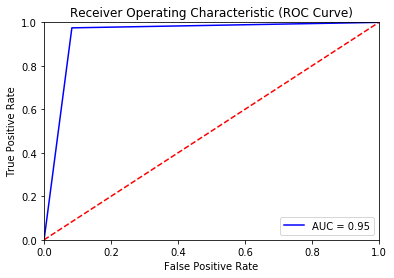

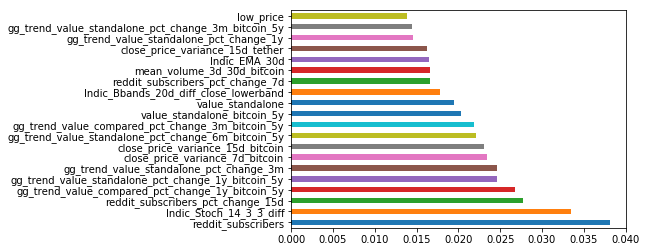

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1683    0]
 [  33    0]]
Accuracy: 0.98
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.98      1.00      0.99      1683
       True       0.00      0.00      0.00        33

avg / total       0.96      0.98      0.97      1716

----------------------------------------------------------



C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


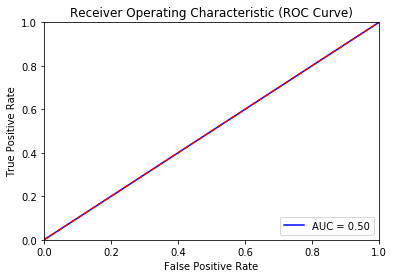

[0.02997915 0.03388809 0.03388809 ... 0.42655537 0.43479998 0.44655537]


In [78]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced").fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=True)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test_scaled)[:,1]
#print(probas)
print(np.sort(probas))

# clf.decision_path(X_test)

In [65]:
# search for correlations
for col in df3.columns.values:
    if df3[col].corr(df3['y_+1d_classif']) > 0.2:
        print(col + ' - ' + str(df3[col].corr(df3['y_+1d_classif'])))

Indic_OBV_uptrend_3d - 0.25805596733583097
y_+6h_classif - 0.3255393414309173
y_+12h_classif - 0.5197543153171319
y_+1d_classif - 1.0
y_+2d_classif - 0.49672290823850385
y_+3d_classif - 0.4508843059542654
y_+7d_classif - 0.27747618069528057


----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Train
----------------------------------------------------------

Confusion Matrix :
 [[3817  116]
 [ 127 1085]]
Accuracy: 0.95
AUC: 0.93


Other Metrics :

             precision    recall  f1-score   support

      False       0.97      0.97      0.97      3933
       True       0.90      0.90      0.90      1212

avg / total       0.95      0.95      0.95      5145

----------------------------------------------------------



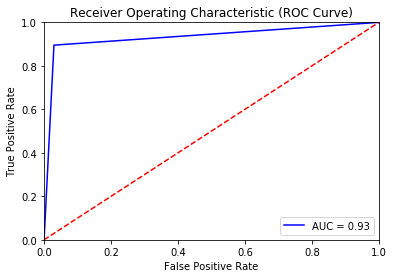

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Test
----------------------------------------------------------

Confusion Matrix :
 [[1382   25]
 [ 243   66]]
Accuracy: 0.84
AUC: 0.60


Other Metrics :

             precision    recall  f1-score   support

      False       0.85      0.98      0.91      1407
       True       0.73      0.21      0.33       309

avg / total       0.83      0.84      0.81      1716

----------------------------------------------------------



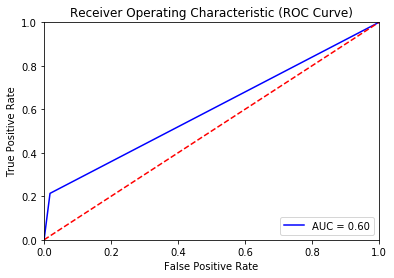

In [66]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

In [27]:
# ------------------ MODEL FITTING ------------------ #

# -----------------------
# ALGO : DUMMY CLASSIFIER
# -----------------------
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('DummyClassifier - Train', dummy_clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns)
show_model_accuracy('DummyClassifier - Test', dummy_clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns)

----------------------------------------------------------
Results for algorithm : DummyClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3896    0]
 [ 965    0]]
Accuracy: 0.80
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.80      1.00      0.89      3896
       True       0.00      0.00      0.00       965

avg / total       0.64      0.80      0.71      4861

----------------------------------------------------------

----------------------------------------------------------
Results for algorithm : DummyClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1483    0]
 [ 138    0]]
Accuracy: 0.91
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.91      1.00      0.96      1483
       True       0.00      0.00      0.00       138

avg / total       0.84      0.91      0.87      1

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Train
----------------------------------------------------------

Confusion Matrix :
 [[2947   91]
 [ 124 1699]]
Accuracy: 0.96
AUC: 0.95


Other Metrics :

             precision    recall  f1-score   support

      False       0.96      0.97      0.96      3038
       True       0.95      0.93      0.94      1823

avg / total       0.96      0.96      0.96      4861

----------------------------------------------------------



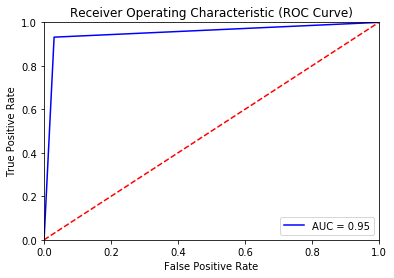

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Test
----------------------------------------------------------

Confusion Matrix :
 [[   0 1327]
 [   0  294]]
Accuracy: 0.18
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.00      0.00      0.00      1327
       True       0.18      1.00      0.31       294

avg / total       0.03      0.18      0.06      1621

----------------------------------------------------------



C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


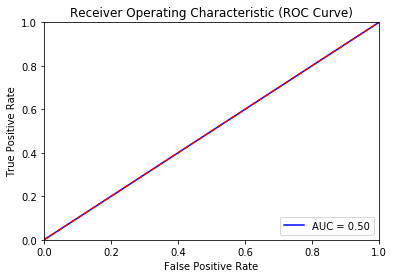

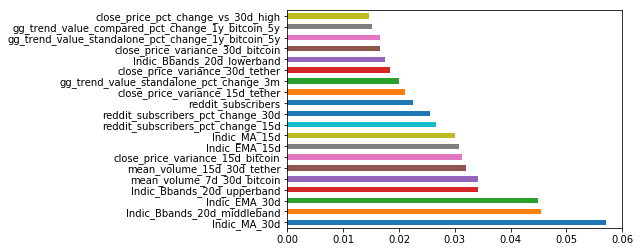

In [21]:
# -----------------------
# ALGO : NAIVE BAYES - GAUSSIANNB
# -----------------------
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('NAIVE BAYES - GaussianNB - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('NAIVE BAYES - GaussianNB - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)


----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3877   19]
 [ 206  759]]
Accuracy: 0.95
AUC: 0.89


Other Metrics :

             precision    recall  f1-score   support

      False       0.95      1.00      0.97      3896
       True       0.98      0.79      0.87       965

avg / total       0.95      0.95      0.95      4861

----------------------------------------------------------



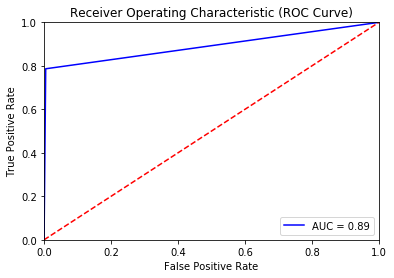

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1326  157]
 [ 111   27]]
Accuracy: 0.83
AUC: 0.54


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.89      0.91      1483
       True       0.15      0.20      0.17       138

avg / total       0.86      0.83      0.85      1621

----------------------------------------------------------



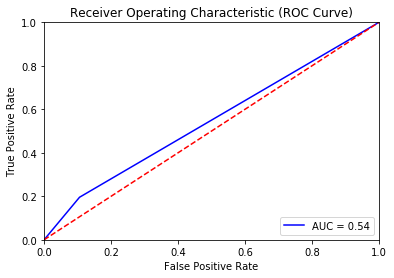

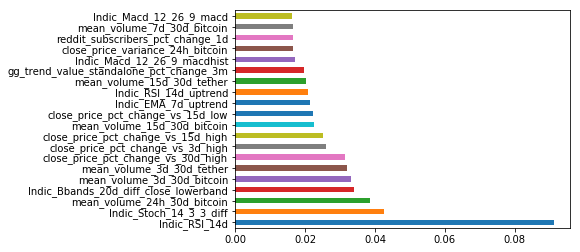

In [29]:
# -----------------------
# ALGO : GradientBoostingClassifier (cf. Module+4 for tuning)
# -----------------------
from sklearn.ensemble import GradientBoostingClassifier

#GradientBoostingClassifier(learning_rate = 0.02, max_depth = 5, random_state = 0)
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('GradientBoostingClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)

----------------------------------------------------------
Results for algorithm : SVM - Train
----------------------------------------------------------

Confusion Matrix :
 [[3778  118]
 [ 275  690]]
Accuracy: 0.92
AUC: 0.84


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.97      0.95      3896
       True       0.85      0.72      0.78       965

avg / total       0.92      0.92      0.92      4861

----------------------------------------------------------



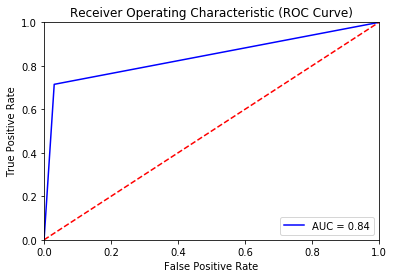

----------------------------------------------------------
Results for algorithm : SVM - Test
----------------------------------------------------------

Confusion Matrix :
 [[1293  190]
 [  99   39]]
Accuracy: 0.82
AUC: 0.58


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.87      0.90      1483
       True       0.17      0.28      0.21       138

avg / total       0.86      0.82      0.84      1621

----------------------------------------------------------



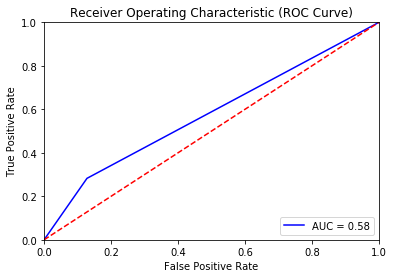

In [31]:
# -----------------------
# ALGO : SVC - (cf. Module+3 for tuning)
# -----------------------
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1).fit(X_train_scaled, y_train[y_to_be_considered])


show_model_accuracy('SVM - Train', svm, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('SVM - Test', svm, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

In [49]:
import seaborn
c = X_train.corr()
#plt.figure(figsize=(10,10))
#seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8))
#plt.show()